
## INM 702 Coursework Code: Task 4 
## Implementation of a fully connected Neural Network on SVHN dataset
### By: Jasveen Kaur and Nikhil Vallakati


### Importing packages

In [37]:
from __future__ import print_function, division
from builtins import range
import numpy as np
from scipy.special import expit
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
import os
import scipy.stats as stats
import time
from sklearn.metrics import confusion_matrix

### Data Loading and Preprocessing

In [30]:
df_svhn_train = loadmat('train_32x32.mat')
df_svhn_test = loadmat('test_32x32.mat')

X_train, y_train = df_svhn_train['X'], df_svhn_train['y']
X_test, y_test = df_svhn_test['X'], df_svhn_test['y']

X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("train images:", X_train.shape)
print("train labels:", y_train.shape)
print("test images:",X_test.shape) 
print("test labels:",y_test.shape)

train images: (73257, 32, 32, 3)
train labels: (73257,)
test images: (26032, 32, 32, 3)
test labels: (26032,)


### Sampling from the dataset

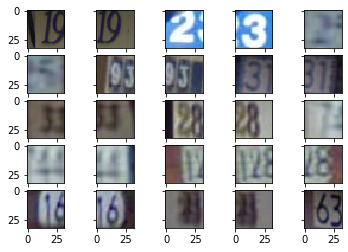

In [31]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[i].reshape(32,32,3)
    ax[i].imshow(img)
plt.show()

### Converting data to grayscale

In [32]:
print("Unique labels", np.unique(y_train) )
n_labels = 10
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

#Convert images from rbg to grayscale
def rgbgray(rgbimages):
    return np.expand_dims(np.dot(rgbimages, [0.2989, 0.5870, 0.1140]), axis=3)

#Transform the images to greyscale
X_train_g = rgbgray(X_train).astype(np.float32)
X_test_g = rgbgray(X_test).astype(np.float32)

print("Training data",X_train_g.shape)
print("Test data", X_test_g.shape)


Unique labels [ 1  2  3  4  5  6  7  8  9 10]
Training data (73257, 32, 32, 1)
Test data (26032, 32, 32, 1)


### Images after grayscale conversion

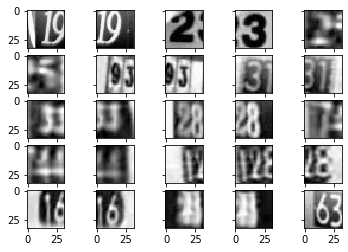

In [33]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train_g[i].reshape(32,32)
    ax[i].imshow(img, cmap='Greys')
plt.show()

### Normalizing the images: used to avoid 0 values as inputs, which might prevent the weights from updating

In [34]:
fact = 0.99/255
X_train = X_train_g.reshape(73257, 1024)*fact + 0.01
X_test = X_test_g.reshape(26032, 1024)*fact + 0.01
print(X_train.shape, X_test.shape)

(73257, 1024) (26032, 1024)


### Encoded Labels: One-hot representation

In [9]:
def one_hot_encode(y):
        onehot = np.zeros((10, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

### Implementing Artificial Neural Network
#### With one input layer, 3 hidden layers and one output layer, optional dropout and L2 regularizer

In [16]:
class neural_network(object):
    def __init__(self, n_hidden1, n_hidden2, n_hidden3, l2, epochs, lr,
                 shuffle, minibatch_size, seed, reg, drop):

        self.random = np.random.RandomState(seed)
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2 
        self.n_hidden3 = n_hidden3
        self.l2 = l2
        self.epochs = epochs
        self.lr = lr
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.reg = reg
        self.drop = drop
     
    #Encoded labels
    def one_hot_encode(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
    
    #relu activation function
    def relu(self, x):
        return np.maximum(0, x) 
    
    #derivative of relu activation function(element)
    def relu_d_element(self, x):
        if x > 0:
            return 1
        elif x <= 0:
            return 0
    
    #derivative of relu activation function(array)
    def relu_d_array(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    #sigmoid activation function
    def sigmoid(self, x):
        return 1. / (1. + np.exp(-np.clip(x, -250, 250)))
    
    #Inverted dropout function definition
    def inverted_drop(self, p, x):
        idropout_mask = (np.random.rand(*x.shape) < p) / p 
        x *= idropout_mask
        return x
     
    #Dropout function definition
    def dropout(self, p, x):
        dropout_mask = np.random.rand(*x.shape) < p
        x*=dropout_mask
        return x
        
    #leaky relu activation function
    def lrelu(self, x):
        alpha = 0.01
        return np.maximum(alpha*x, x) 
    
    #derivative of leaky relu
    def lrelu_d(self, x):
        alpha = 0.01
        relu_d = np.where(x <= 0, alpha, 1.0) 
        return relu_d
        
    #softmax function definition   
    def softmax_basic(self, x):
        exp_scores = np.exp(x)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs

    #softmax to calculate gradient
    def softmax_grad(self, s): 
        #a = np.diag(np.diag(s))
        S_vector = np.diag(s)
        S_matrix = np.transpose(S_vector)
        return np.diag(s) - (S_matrix * np.transpose(S_matrix))
    
    #forward pass with optional dropout
    def forward_pass(self, X):
      
        z1 = np.dot(X, self.w1) + self.b1
        a1 = self.lrelu(z1)
       
        if self.drop:
            a1 = self.inverted_drop(0.8, a1)

        z2 = np.dot(a1, self.w2) + self.b2
        a2 = self.lrelu(z2)
        
        if self.drop:
            a2 = self.inverted_drop(0.8, a2)
        
        z3 = np.dot(a2, self.w3) + self.b3
        a3 = self.lrelu(z3)
        
        if self.drop:
            a3 = self.inverted_drop(0.8, a3)
        
        z_out = np.dot(a3, self.w_out) + self.b_out
        a_out = self.softmax_basic(z_out)

        return z1, a1, z2, a2, z3, a3, z_out, a_out
  
    #Computing the loss term with additional L2 regularizer
    def compute_cost(self, y_enc, a_out):

        y_enc = y_enc.argmax(axis=1)
        m = y_enc.shape[0]
        log_probs = -np.log(a_out[range(m),y_enc])
        loss = np.sum(log_probs) / m
        
        #regularization term
        if self.reg:
            reg_loss = 0.5*self.l2*np.sum(self.w1*self.w1) + 0.5*self.l2*np.sum(self.w2*self.w2)+ 0.5*self.l2*np.sum(self.w3*self.w3) + 0.5*self.l2*np.sum(self.w_out*self.w_out)
            loss += reg_loss
            
        return loss
    
    #predicting the output
    def predict_out(self, X):
        z1, a1, z2, a2, z3, a3, z_out, a_out = self.forward_pass(X)
        y_pred = np.argmax(a_out, axis=1)
        return y_pred
    
    #Calculating the accuracy
    def accuracy(self, y, y_pred, X):
        return ((np.sum(y.T == y_pred)).astype(np.float) / X.shape[0])
    
    #Training the network
    def train(self, X_train, y_train, X_test, y_test):
        
        n_output = np.unique(y_train).shape[0]  
        n_features = X_train.shape[1]
        y_train_enc = self.one_hot_encode(y_train, n_output)

        #Initializing the weights
        
        #hidden layer 1
        self.b1 = np.zeros(self.n_hidden1)
        self.w1 = self.random.normal(loc=0.0, scale=0.1,size=(n_features, self.n_hidden1))
        
        #hidden layer 2
        self.b2 = np.zeros(self.n_hidden2)
        self.w2 = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden1, self.n_hidden2))
        
        #hidden layer 3
        self.b3 = np.zeros(self.n_hidden3)
        self.w3 = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden2, self.n_hidden3))
        
        #output layer
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden3, n_output))
        
        #defining a dictionary to save the results
        self.results = {'cost': [], 'train_acc': [], 'test_acc': []}        
        start_time = time.time()
        
        #training epochs
        for i in range(self.epochs):

            samples = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(samples)

            #minibatches
            for start_idx in range(0, samples.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = samples[start_idx:start_idx + self.minibatch_size]

                
                #forward propagation
             
                z1, a1, z2, a2, z3, a3, z_out, a_out = self.forward_pass(X_train[batch_idx])
                #cost = self.compute_cost(y_train_enc[batch_idx], a_out)

                # Backpropagation
            
                sigma_out = a_out - y_train_enc[batch_idx]
                relu_derivative3 = self.lrelu_d(a3)
                sigma_h3 = (np.dot(sigma_out, self.w_out.T) * relu_derivative3)
                
                relu_derivative2 = self.lrelu_d(a2)
                sigma_h2 = (np.dot(sigma_h3, self.w3.T) * relu_derivative2)
                
                relu_derivative1 = self.lrelu_d(a1)
                sigma_h1 = (np.dot(sigma_h2, self.w2.T) * relu_derivative1)
                
                grad_w3 = np.dot(a2.T, sigma_h3)
                grad_w2 = np.dot(a1.T, sigma_h2)
                grad_w1 = np.dot(X_train[batch_idx].T, sigma_h1)
                grad_b3 = np.sum(sigma_h3, axis=0)
                grad_b2 = np.sum(sigma_h2, axis=0)
                grad_b1 = np.sum(sigma_h1, axis=0)

                grad_w_out = np.dot(a3.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                delta_w3 = (grad_w3 + self.l2*self.w3)
                delta_w2 = (grad_w2 + self.l2*self.w2)
                delta_w1 = (grad_w1 + self.l2*self.w1)
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                
                delta_b3 = grad_b3
                delta_b2 = grad_b2
                delta_b1 = grad_b1
                delta_b_out = grad_b_out
                
                self.w3 -= self.lr * delta_w3
                self.w2 -= self.lr * delta_w2
                self.w1 -= self.lr * delta_w1
                self.w_out -= self.lr * delta_w_out
                
                self.b3 -= self.lr * delta_b3
                self.b2 -= self.lr * delta_b2
                self.b1 -= self.lr * delta_b1           
                self.b_out -= self.lr * delta_b_out

        
            #evaluating the trained model with updated weights
            z1, a1, z2, a2, z3, a3, z_out, a_out = self.forward_pass(X_train)
            
            cost = self.compute_cost(y_enc=y_train_enc, a_out=a_out)
            
            y_train_pred = self.predict_out(X_train)
            y_test_pred = self.predict_out(X_test)

            train_acc = self.accuracy(y_train, y_train_pred, X_train)
            test_acc = self.accuracy(y_test, y_test_pred, X_test)
            
            print("epoch:", i+1)
            
            print("Train Accuracy:","{:.2f}".format(train_acc*100),"% ||","Test Accuracy:","{:.2f}".format(test_acc*100),"% ||","loss:","{:.3f}".format(cost))
            print("Training time: {}".format(time.strftime("%Mm %Ss", time.gmtime(time.time()-start_time))))
            
            self.results['cost'].append(cost)
            self.results['train_acc'].append(train_acc)
            self.results['test_acc'].append(test_acc)

        return self

### Initializing the training parameters

In [17]:
Model = neural_network(n_hidden1=512,n_hidden2=128, n_hidden3 = 64,
                  l2=0.0001, 
                  epochs=30, 
                  lr=0.0005,
                  minibatch_size=16, 
                  shuffle=True,
                  seed=1,
                  reg = True,
                  drop = True)

### Training the neural network

In [18]:
Model.train(X_train=X_train, 
       y_train=y_train,
       X_test=X_test,
       y_test=y_test)

epoch: 1
Train Accuracy: 18.88 % || Test Accuracy: 19.40 % || loss: 2.517
Training time: 00m 50s
epoch: 2
Train Accuracy: 27.18 % || Test Accuracy: 27.49 % || loss: 2.319
Training time: 01m 42s
epoch: 3
Train Accuracy: 40.50 % || Test Accuracy: 39.52 % || loss: 2.027
Training time: 02m 32s
epoch: 4
Train Accuracy: 47.62 % || Test Accuracy: 46.60 % || loss: 1.845
Training time: 03m 22s
epoch: 5
Train Accuracy: 50.55 % || Test Accuracy: 48.98 % || loss: 1.768
Training time: 04m 10s
epoch: 6
Train Accuracy: 55.51 % || Test Accuracy: 53.74 % || loss: 1.653
Training time: 04m 59s
epoch: 7
Train Accuracy: 57.85 % || Test Accuracy: 55.35 % || loss: 1.591
Training time: 05m 49s
epoch: 8
Train Accuracy: 60.33 % || Test Accuracy: 58.07 % || loss: 1.536
Training time: 06m 38s
epoch: 9
Train Accuracy: 61.28 % || Test Accuracy: 58.52 % || loss: 1.520
Training time: 07m 27s
epoch: 10
Train Accuracy: 63.52 % || Test Accuracy: 60.47 % || loss: 1.449
Training time: 08m 17s
epoch: 11
Train Accuracy: 63.

### Graph for the loss function

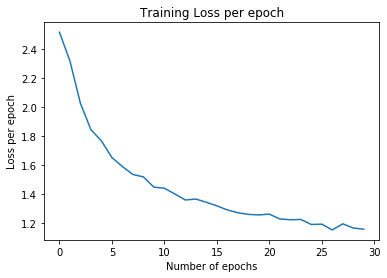

In [27]:
plt.plot(range(Model.epochs), Model.results['cost'])
plt.ylabel('Loss per epoch')
plt.xlabel('Number of epochs')
plt.title('Training Loss per epoch')
plt.show()

### Graph for the Accuracy

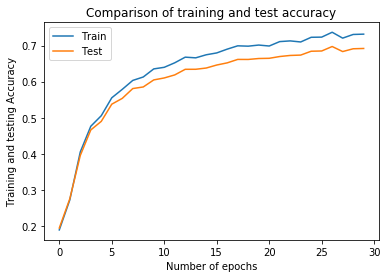

In [28]:
plt.plot(Model.results['train_acc'], 
         label='Train')
plt.plot(Model.results['test_acc'], 
         label='Test')
plt.ylabel('Training and testing Accuracy')
plt.xlabel('Number of epochs')
plt.legend()
plt.title('Comparison of training and test accuracy')
plt.show()

### Confusion matrix

In [35]:
y_test_pred = Model.predict_out(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])
print("Total accuracy: %.2f%%" % (acc*100))

Total accuracy: 69.32%


[[1111  124   70   67   52   60   72   69   24   95]
 [  70 4387  128  119  113   60   38  131   17   36]
 [  28  269 3095  170  119   74   40  246   39   69]
 [  40  355  181 1770   54  206   27   80   48  121]
 [  46  244   97   51 1878   42   53   20   28   64]
 [  40  148   66  217   59 1563  139   27   50   75]
 [ 144  124   65   52  160  218 1114   15   66   19]
 [  14  221  222   54   11   27   22 1413    9   26]
 [  89  123   67   65   73  198  156   11  754  124]
 [ 137  127   93   63   43   89   13   43   27  960]]


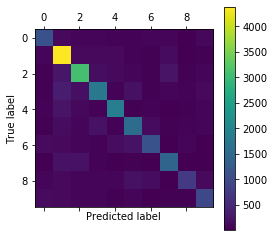

In [36]:
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The neural network is able to achieve 73.16% accuracy on train set, 69.19% accuracy on test set and a loss value of 1.15, using Learky Relu as activation, inverted dropout and a L2 regularization term.